<font size=5>**Verificação da Concordância na Primeira Etapa (Treinamento 1)**</font>

Quantificar grau de entendimento entre os anotadores na primeira etapa de treinamento.

<font size=3>**Resultados Esperados**</font>

1. Matriz com a concordância (kappa) entre anotadores, de tamanho n x n (sendo n o total de anotadores).

2. Matriz com o percentual de concordância entre anotadores para cada label, de tamanho L x L (sendo L o total de labels)

3. Lista anotadores que tiveram uma concordância média de kappa superior a 0.75

A verificação de concordância é feita olhando a anotação token a token, como abaixo.

<mark style="background: cyan; border-radius: 0.2em;margin:0.1em">O</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">Plenário</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">desta</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">Corte</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">,</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">em</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">24/11/2010</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">,</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">no</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">julgamento</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">da</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">ADC</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">nº</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">16/DF</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">,</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">Relator</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">o</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">Ministro</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em">Cezar</mark><mark style="background: cyan; border-radius: 0.2em;margin:0.1em"> </mark>

$\;\downarrow\;\downarrow\quad\;\downarrow\quad\;\downarrow\quad\downarrow \dots$

<mark style="background: orange; border-radius: 0.2em;margin:0.1em">O</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">Plenário</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">desta</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">Corte</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">,</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">em</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">24/11/2010</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">,</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">no</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">julgamento</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">da</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">ADC</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">nº</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">16/DF</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">,</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">Relator</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">o</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">Ministro</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em">Cezar</mark><mark style="background: orange; border-radius: 0.2em;margin:0.1em"> </mark>

<font size=3>**Definições**</font>

Seja uma matriz de confusão entre anotadores A e B com 3 categorias, como abaixo

\begin{matrix}
    &B(1)&B(2)&B(3)\\
A(1)&a_{11}&a_{12}&a_{13}\\
A(2)&a_{21}&a_{22}&a_{23}\\
A(3)&a_{31}&a_{32}&a_{33}
\end{matrix} 

<font size=3>**Percentual de concordância por label**</font>

Percentual de concordância por label (x,y) é o percentual do total de classificações onde A anotou label x e B anotou label y.

(Ou seja, a matriz de concordância por label é a matriz de confusão normalizada)

<font size=3>**Cohens Kappa**</font>

$$ \kappa = \frac{p_o - p_e}{1 - p_e} $$

- $p_e$ é a probabilidade de concordarem por sorte
- $p_o$ é a percentual total de concordância

<font size=3>**Exemplo**</font>

Seja $ \mathcal{M} $  a matriz de confusão mostrada acima. Podemos calcular todas as métricas de interesse.
<br>
<br>
<center>Percentual total de concordância</center>
$$ p_o = \frac{Trace(\mathcal{M})}{\sum_{i,j}a_{i,j}} $$
<br>
<br>
<center> A probabilidade de A e B concordarem por sorte ao categorizar como label (2) é</center>

$$ p_{2A}\cdot p_{2B}$$
<br>
<center>Onde</center>

$$ p_{2A} = \frac{a_{2,1}+a_{2,2}+a_{2,3}}{\sum_{i,j}a_{i,j}} $$

$$ p_{2B} = \frac{a_{1,2}+a_{2,2}+a_{3,2}}{\sum_{i,j}a_{i,j}} $$
<br>
<br>
<center>A probabilidade de A e B concordarem por sorte num item qualquer é a soma da probabilidade de A e B concordarem em 1, em 2 e em 3:</center>
$$ p_e = p_{1A}p_{1B} + p_{2A}p_{2B} + p_{3A}p_{3B}$$

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix

<font size=5>**0. Funções Auxiliares**</font>

In [132]:
def tag_num(y):
    """
    Função para transformar vetor de tags complexas em vetor de labels numéricos.
    """
    
    # Lista de todas as tags possíveis
    tags = ['O', 'B_Precedente', 'I_Precedente', 'B_Ref. Legislativa',
       'I_Ref. Legislativa', 'B_Pessoa', 'I_Pessoa', 'B_Doutrinador',
       'I_Doutrinador']
    
    # Montando uma correspondência entre tags e posição na matrix de confusão
    tags_dict = {y:x for (x,y) in enumerate(tags)}
    
    # Vetor com labels numéricos no lugar da 
    y_new = np.vectorize(tags_dict.get)(y)
    
    return y_new

In [133]:
def conf_matrix(y1, y2):
    """
    Função para montar a matrix de confusão entre vetores de classificação y1 e y2
    """
    
    # Macete usado pelo sklearn: ao montar matrizes esparsas COO com scipy, 
    # índices repetidos da matriz são somados na montagem
    weight = np.ones(len(y1))
    confusion = scipy.sparse.coo_matrix((weight, (y1, y2)), shape=(9, 9))
    
    return np.array(confusion.toarray())

In [134]:
def cohen_kappa_token(confusion_matrix):
    """
    Função para cálculo do Cohen's Kappa a partir de uma matriz de confusão
    """
    
    # Calculando o Cohen's Kappa
    total = confusion_matrix.sum() # Total de Tokens avaliados
    po = np.trace(confusion_matrix)/total # Percentagem relativa de concordância
    
    # Vetor de probabilidades de 1 e de 2
    p1 = confusion_matrix.sum(axis=1)/total # Soma das classificações nas linhas
    p2 = confusion_matrix.sum(axis=0)/total # Soma das classificações nas colunas
    
    # Calculando a chance de 1 e 2 concordarem por sorte
    pe = np.dot(p1, p2)
    
    # Calculando Cohen's Kappa
    kappa = (po-pe)/(1.0-pe)
    
    return kappa

In [135]:
def percentual_by_label(confusion_matrix):
    """
    Função para cálculo do percentual de concordância por label a partir de uma matriz de confusão
    """
    
    # Calculo do percentual por label
    label_percentual = confusion_matrix/confusion_matrix.sum()
    
    return label_percentual

In [136]:
def percentual_total(confusion_matrix):
    """
    Função para cálculo do percentual de concordância total a partir de uma matriz de confusão
    """
    
    #Calculando a concordância percentual total
    total = confusion_matrix.sum() # Total de Tokens avaliados
    po = np.trace(confusion_matrix)/total # Percentagem relativa de concordância
    
    return np.trace(confusion_matrix)

In [137]:
def analise_dados(y1, y2):
    
    y1n = tag_num(y1)
    y2n = tag_num(y2)
    
    confusion_matrix = conf_matrix(y1n, y2n)
    
    kappa = cohen_kappa_token(confusion_matrix)
    label_percentuais = percentual_by_label(confusion_matrix)
    concord_percent = percentual_total(confusion_matrix)
    
    return kappa, concord_percent, label_percentuais

# Pegando arquivos de dados

Vamos assumir que todos os dados com a anotação de cada arquivo se encontram em:

<center><font color='red' >./dados/*/treino_1/Documentos/combinado.csv</font></center>

Que são os arquivos de anotação dos quatro textos já combinados em um único csv. No lugar do asterico, temos o número de matrícula dos alunos.

In [2]:
# Encontra todos os csv's do treino dentro das pastas de 'mock'
extension = 'csv'
all_filenames = [i for i in glob.glob('mock/*/treino_1/Documentos/combinado.csv')]

In [3]:
all_filenames.sort()
size = len(all_filenames)

## Calculando as métricas

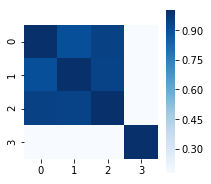

In [138]:
kappa_matrix = np.zeros((size,size))
percent_matrix = np.zeros((size,size))
conf_matrices = []

for n in range(size):
    for m in range(size):

        df1_temp = pd.read_csv(all_filenames[n], delimiter=';', na_values='NaN')
        df2_temp = pd.read_csv(all_filenames[m], delimiter=';', na_values='NaN')
        
        Tags1 = df1_temp.loc[:, 'Tag'].values
        Tags2 = df2_temp.loc[:, 'Tag'].values
        
        k, percent, matriz_labels = analise_dados(Tags1, Tags2)
        
        kappa_matrix[dic_pos[n], dic_pos[m]] = k
        percent_matrix[dic_pos[n], dic_pos[m]] = percent
        conf_matrices.append(matriz_labels)
        
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(kappa_matrix, ax=ax, square=True, cmap='Blues')